# Time Series Analysis-Well Production Forecasting

Decline curve analysis (DCA) is a graphical procedure used for analyzing declining production rates and forecasting future performance of oil and gas wells. Oil and gas production rates decline as a function of time; loss of reservoir pressure, or changing relative volumes of the produced fluids, are usually the cause. Fitting a line through the performance history and assuming this same trend will continue in future forms the basis of DCA concept(PetroWiki).

The basic assumption in this procedure is that whatever causes controlled the trend of a curve in the past will continue to govern its trend in the future in a uniform manner. J.J. Arps collected these ideas into a comprehensive set of equations defining the exponential, hyperbolic and harmonic declines.(Representative figure below) 

![alt text](DCA_Arps.jpg "Conventional Decline Curve Analysis")

The major application of DCA in the industry today is still based on equations and curves described by Arps. Arps applied the equation of Hyperbola to define three general equations to model production declines.

This notebook aims at replacing the traditional DCA and discusses the application of the widely accepted concepts of time series analysis for forecasting well production data by analyzing statistical trends from historical data. 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']= 15, 16

import warnings
warnings.filterwarnings('ignore')


In [5]:
column=['Month','Production_rate']
data = pd.read_csv('ProductionData2.csv', names = column)
data.head(15)

,Month,Production_rate
0,6/1/2004,0.000000
1,7/1/2004,2428.258065
2,8/1/2004,2175.129032
3,9/1/2004,1812.266667
4,10/1/2004,1641.741935
5,11/1/2004,1522.433333
6,12/1/2004,1573.258065
7,1/1/2005,1558.129032
8,2/1/2005,1308.214286
9,3/1/2005,1579.354839


The data is for an anonymous well with oil production rate available for 10 years.

In [6]:
data.describe()

,Production_rate
count,112.000000
mean,953.253699
std,497.332119
min,0.000000
25%,556.826613
50%,883.765591
75%,1381.879032
max,2428.258065


In [7]:
data['Production_rate'].isnull().value_counts()

False    112
Name: Production_rate, dtype: int64

Hence we see that none of the production data is missing from the available data.

In [8]:
data.dtypes

Month               object
Production_rate    float64
dtype: object

Currently the available month column is in 'Oblect' format, let's convert it to datatime64[ns] (data-time) object in pandas which stores time information and allows us to perform some operations really fast.

In [9]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%m/%d/%Y')
data = pd.read_csv('ProductionData2.csv',names = column, parse_dates=['Month'], index_col=['Month'],date_parser=dateparse)


In [10]:
#Taking production data after the start of production
ts = data['Production_rate'][1:]
ts.head()

Month
2004-07-01    2428.258065
2004-08-01    2175.129032
2004-09-01    1812.266667
2004-10-01    1641.741935
2004-11-01    1522.433333
Name: Production_rate, dtype: float64

## Stationarity Requirement of Time Series

The Time series modeling algorithms assume that the series is stationary. A time series is said to be stationary when the mean is not varying locally i.e. it is constant with thme. Additionally the variance and covariance of the i th term and the (i + m)th termshould not be a function of time.

For cases when there is no stationarity in the time series it needs to be converted to made stationary and then apply stochastic techniques for prediction/forecasting.

Let's visualize the production trend available for the well.

Text(0,0.5,'Production rate (Barrels per Day)')

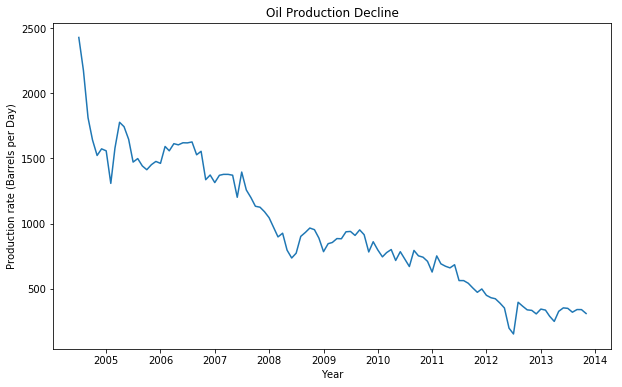

In [11]:
plt.figure(figsize=(10,6))
plt.plot(ts)
plt.title('Oil Production Decline')
plt.xlabel('Year')
plt.ylabel('Production rate (Barrels per Day)')

As expected, the production has a declining trend owing to loss of reservoir pressure, or changing relative volumes of the produced fluids. Thus this declining trend makes the local mean production rate a function of the time (Month-Year). Hence this time series is non-stationary and needs to be made stationary.

The following code block implements Dickey-Fuller test which can provide a quick check and confirmatory evidence that your time series is stationary or non-stationary.(Machine Learning mastery Website: https://machinelearningmastery.com/time-series-data-stationary-python/)

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [12]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    rolmean = pd.rolling_mean(timeseries, window =10)
    rolstd = pd.rolling_std(timeseries, window =10)
    
    plt.figure(figsize=(10,6))
    orig = plt.plot(timeseries, label ='Original')
    mean = plt.plot(rolmean, label = 'Rolling Mean')
    std = plt.plot(rolstd, label = 'Rolling Standard Deviation')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

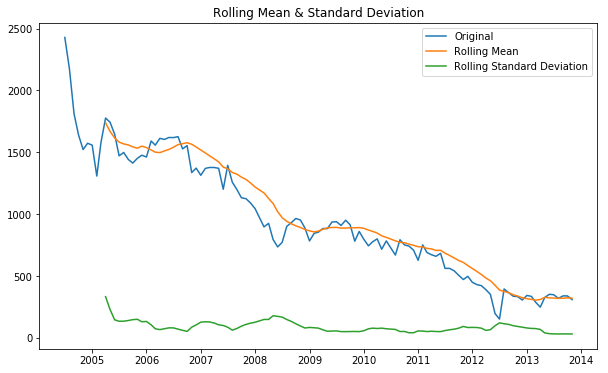

Results of Dickey-Fuller Test:
Test Statistic                  -2.285177
p-value                          0.176793
#Lags Used                       1.000000
Number of Observations Used    109.000000
Critical Value (5%)             -2.888444
Critical Value (1%)             -3.491818
Critical Value (10%)            -2.581120
dtype: float64


In [13]:
test_stationarity(ts)

Indeed the decline curve is nonstationary as we can see the rolling mean and rolling standard deviation have a decreasing trend. The p-value for the Dickey Fuller test done here os 0.177 (>>0.05), hence it Failed to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

## Transforming the decline curve to Stationary Time Series

The presence of time trends and seasonality make the time series non stationary. The declining trend for production data is very intuitive. However presence of seasonality  is difficult to comprehend and will be handled using statistical techniques.

The trend removal done here is proportional to the magnitudes, hence the time series has been converted to logarithmic representation before analysis.

### Trend Elimination- Moving Average Approach

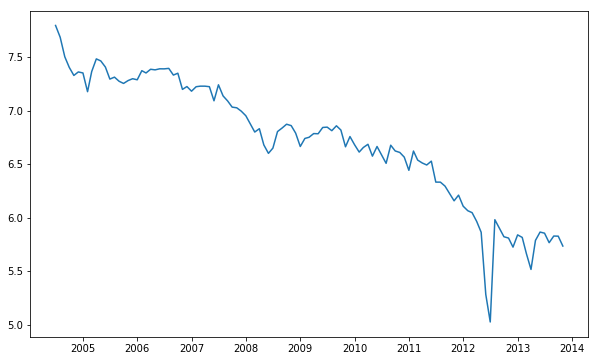

In [14]:
ts_log = np.log(ts)
plt.figure(figsize=(10,6))
plt.plot(ts_log, label= 'log(Original)')

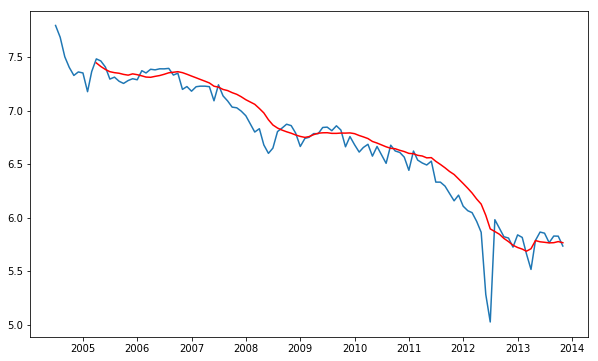

In [15]:
moving_avg = pd.rolling_mean(ts_log,10)
plt.figure(figsize=(10,6))
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [16]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(20)

Month
2004-07-01         NaN
2004-08-01         NaN
2004-09-01         NaN
2004-10-01         NaN
2004-11-01         NaN
2004-12-01         NaN
2005-01-01         NaN
2005-02-01         NaN
2005-03-01         NaN
2005-04-01    0.037745
2005-05-01    0.051762
2005-06-01    0.022391
2005-07-01   -0.069040
2005-08-01   -0.041798
2005-09-01   -0.074856
2005-10-01   -0.084406
2005-11-01   -0.050228
2005-12-01   -0.045413
2006-01-01   -0.047657
2006-02-01    0.048346
Name: Production_rate, dtype: float64

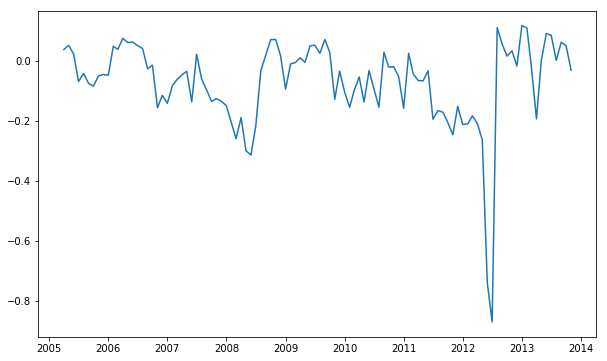

In [17]:
ts_log_moving_avg_diff.dropna(inplace =True)
plt.figure(figsize=(10,6))
plt.plot(ts_log_moving_avg_diff)

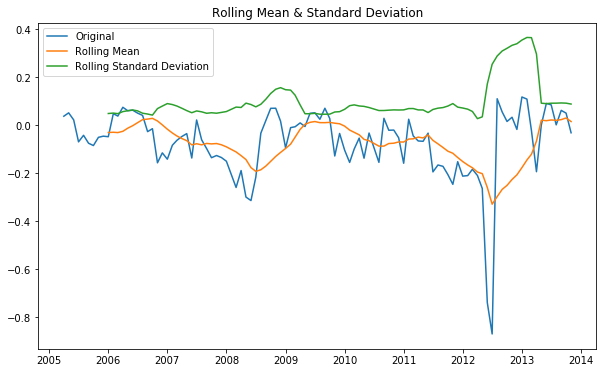

Results of Dickey-Fuller Test:
Test Statistic                  -5.134034
p-value                          0.000012
#Lags Used                       0.000000
Number of Observations Used    101.000000
Critical Value (5%)             -2.890611
Critical Value (1%)             -3.496818
Critical Value (10%)            -2.582277
dtype: float64


In [18]:
test_stationarity(ts_log_moving_avg_diff)

The rolling values appear to be varying slightly but there is no specific trend.The p-value for the Dickey Fuller test done here os 0.000012 (<<0.05), hence the null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

### Trend Elimination- Exponentially Weighted Moving Average Approach

Trend removal using simple moving approach requires a time window to be defined for the moving average calculation. However the definition of this time period is not very straightforward. We take a ‘weighted moving average’ where more recent values are given a higher weight. A popular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor. (http://pandas.pydata.org/pandas-docs/stable/computation.html#exponentially-weighted-moment-functions) 

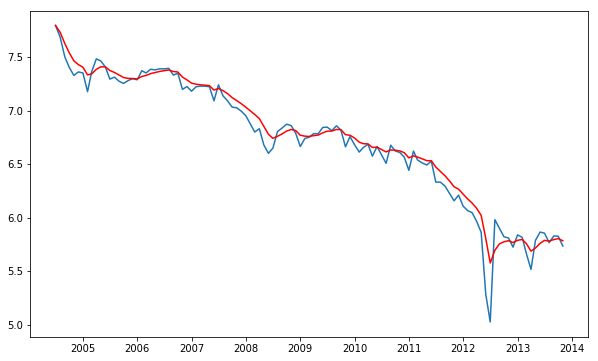

In [19]:
expweighted_avg = pd.ewma(ts_log, halflife = 2)
plt.figure(figsize=(10,6))
plt.plot(ts_log)
plt.plot(expweighted_avg, color ='red')

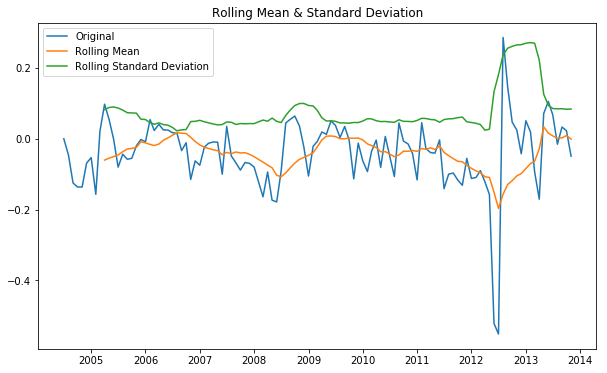

Results of Dickey-Fuller Test:
Test Statistic                -6.757820e+00
p-value                        2.842041e-09
#Lags Used                     1.000000e+00
Number of Observations Used    1.090000e+02
Critical Value (5%)           -2.888444e+00
Critical Value (1%)           -3.491818e+00
Critical Value (10%)          -2.581120e+00
dtype: float64


In [20]:
ts_log_ewma_diff = ts_log - expweighted_avg
test_stationarity(ts_log_ewma_diff)

The rolling values appear to be varying slightly but there is no specific trend.The p-value for the Dickey Fuller test done here os 0.000018 (<<0.05), hence the null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

## Trend and Seasonality Removal Using Differencing

One of the most common methods of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity. First order differencing can be done in Pandas as:

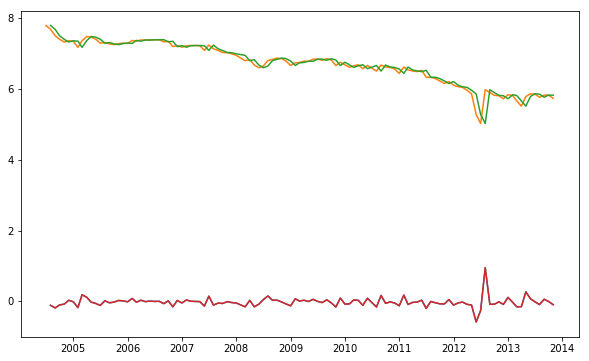

In [21]:
ts_log_diff = ts_log - ts_log.shift()
plt.figure(figsize=(10,6))
plt.plot(ts_log_diff)
plt.plot(ts_log)
plt.plot(ts_log.shift())
plt.plot(ts_log.diff())

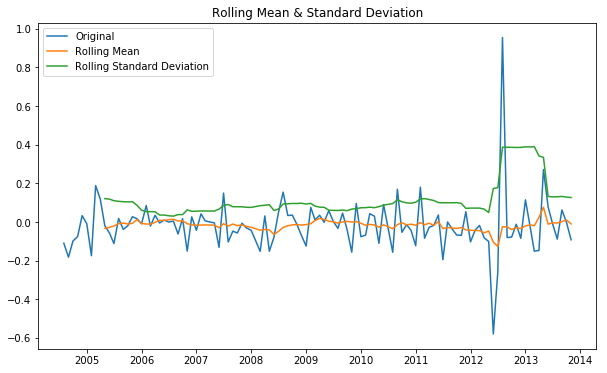

Results of Dickey-Fuller Test:
Test Statistic                -1.038459e+01
p-value                        2.096028e-18
#Lags Used                     1.000000e+00
Number of Observations Used    1.080000e+02
Critical Value (5%)           -2.888697e+00
Critical Value (1%)           -3.492401e+00
Critical Value (10%)          -2.581255e+00
dtype: float64


In [22]:
ts_log_diff.dropna(inplace=True)
plt.figure(figsize=(10,6))
test_stationarity(ts_log_diff)

We can see that compared to the earlier approaches, the Rolling mean and Rolling Standard Deviations are least varying while trend and seasonality are handled using the Differencing method. 

## Decline Curve Forecasting- ARIMA

Source: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
An ARIMA model is a class of statistical models for analyzing and forecasting time series data.

It explicitly caters to a suite of standard structures in time series data, and as such provides a simple yet powerful method for making skillful time series forecasts.

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration.

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.
Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:

p: The number of lag observations included in the model, also called the lag order.
d: The number of times that the raw observations are differenced, also called the degree of differencing.
q: The size of the moving average window, also called the order of moving average.
A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model.

A value of 0 can be used for a parameter, which indicates to not use that element of the model. This way, the ARIMA model can be configured to perform the function of an ARMA model, and even a simple AR, I, or MA model.

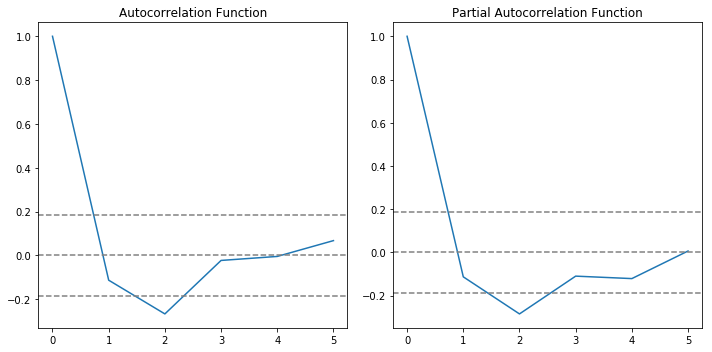

In [23]:
ts_log_diff_active = ts_log_diff

from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff_active, nlags=5)
lag_pacf = pacf(ts_log_diff_active, nlags=5, method='ols')
plt.figure(figsize=(10,5))
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff_active)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff_active)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#plt.figure(figsize=(15,5))

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff_active)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff_active)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()


In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:

p – The lag value where the PACF chart crosses the upper confidence interval for the first time. Here, p=1. This can be taken as the starting value.
q – The lag value where the ACF chart crosses the upper confidence interval for the first time. Here, q=1. This can be taken as the starting value.

In [24]:
from statsmodels.tsa.arima_model import ARIMA

Auto-Regressive Model (p=2, d=1, q=0)

Text(0.5,1,'RSS: 1.9042')

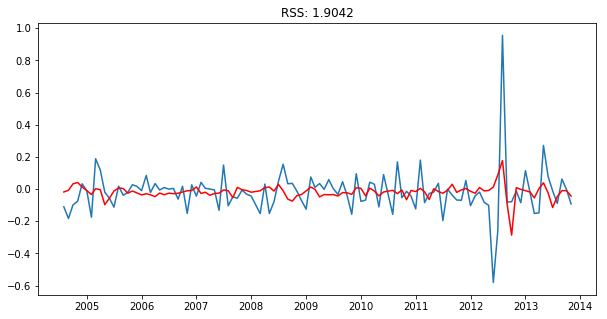

In [25]:
model_AR = ARIMA(ts_log, order=(2, 1, 0))  
results_ARIMA_AR = model_AR.fit(disp=-1)  
plt.figure(figsize=(10,5))
plt.plot(ts_log_diff_active)
plt.plot(results_ARIMA_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA_AR.fittedvalues-ts_log_diff)**2))

Moving Average Model (p=0, d=1, q=2)

Text(0.5,1,'RSS: 1.8418')

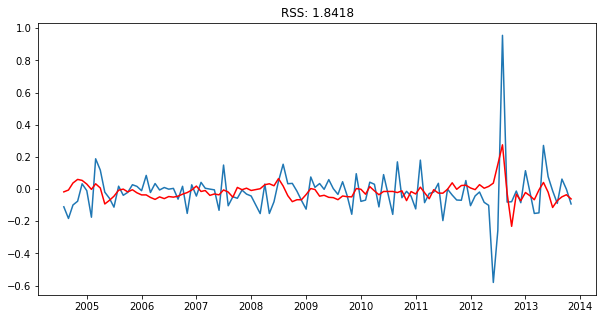

In [26]:
model_MA = ARIMA(ts_log, order=(0, 1, 2))  
results_ARIMA_MA = model_MA.fit(disp=-1)  
plt.figure(figsize=(10,5))
plt.plot(ts_log_diff_active)
plt.plot(results_ARIMA_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA_MA.fittedvalues-ts_log_diff)**2))

Combined ARIMA model (p=2, d=1, q=2)

Text(0.5,1,'RSS: 1.8398')

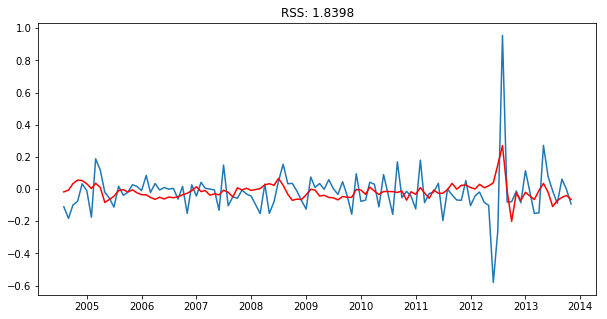

In [27]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.figure(figsize=(10,5))
plt.plot(ts_log_diff_active)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [28]:
predictions_ARIMA_diff = pd.Series(results_ARIMA_AR.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
2004-08-01   -0.018007
2004-09-01   -0.007469
2004-10-01    0.032414
2004-11-01    0.040739
2004-12-01    0.013461
dtype: float64

In [29]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
2004-08-01   -0.018007
2004-09-01   -0.025477
2004-10-01    0.006938
2004-11-01    0.047677
2004-12-01    0.061138
dtype: float64

In [30]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
2004-07-01    7.794929
2004-08-01    7.776922
2004-09-01    7.769453
2004-10-01    7.801867
2004-11-01    7.842606
dtype: float64

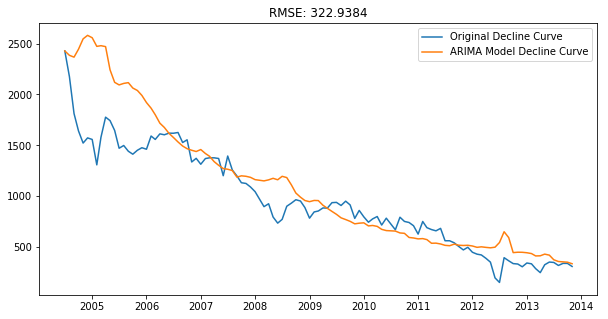

In [31]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.figure(figsize=(10,5))
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))
plt.gca().legend(('Original Decline Curve','ARIMA Model Decline Curve'))

This prediction curve isn't a perfect prediction, however it does cover the inherent trends and seasonality of the decline curve when compared to the traditional decline curve analysis methids.